# Replication - UKB - Infernce and Output

Here we provide a notebook to replicate the inference/prediction/concordance/forestplot scripts from the UKB analysis in the paper

This also showcases an example analysis for a data set that could not be fit into memory (here only out of illustrative purpose).
Originally we have used sepereate scripts as we could not load the full data in memory and needed to run seperat sections of the code. 
As the simulated dataset is actually not too large, we combine all of the steps in a single file here.

The notebook replicates the results in:
- /ukb/output/*

The main script can be found at:
- /ukb/scripts/01_inference.py
- /ukb/scripts/02_prediction.py
- /ukb/scripts/03_breslow.py 
- /ukb/scripts/04_concordance.py
- /ukb/scripts/05_forestplot.py


In [1]:
# google colab specific - installing probcox
!pip3 install torch==1.7.0
!pip3 install pyro-ppl==1.5.1
!pip3 install probcox
!pip3 install h5py

In [2]:
# used to save data to google drive - from which we read data on demand
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# set drive to fake data folder
dir_fakedata = '/content/drive/MyDrive/Colab Notebooks/ProbCox/replication/ukb/fakedata/'

In [4]:
# Modules
# =======================================================================================================================
import os
import sys
import shutil
import subprocess
import tqdm
import h5py

import numpy as np
import pandas as pd

import torch
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader, Sampler

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor
np.random.seed(4523)
torch.manual_seed(9845)

In [5]:
# Dataloader
# =======================================================================================================================
# custom functions for collating samples loaded and how to sample them (randomly)
class RandomSampler(Sampler):
    def __init__(self, ids):
        self.ids_len = len(ids)
        self.ids = ids

    def __iter__(self):
        return iter(np.random.choice(self.ids, self.ids_len, replace=False).tolist())

    def __len__(self):
        return self.ids_len

# stack samples without adding additional dimension
def custom_collate(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) > 0:
        return([torch.cat([item[ii] for item in batch], 0) for ii in range(len(batch[0]))])
    else:
        return(None, None)


In [6]:
# Dataloader
# =======================================================================================================================
# dataloader object
class FAKE_UKB(Dataset):
    """"""
    def __init__(self, dir, dtype=dtype):
        # open hdf5 file
        self.f = h5py.File(dir, 'r') 
        self.dtype = dtype

    def __len__(self):
        # epoch size
        return(25600)

    def __disconnect__(self):
        self.f.close()

    def __getitem__(self, ii, dtype=dtype):
        time = torch.from_numpy(self.f['_' + str(ii)]['surv'][:])
        X = torch.from_numpy(self.f['_' + str(ii)]['X'][:])
        return(time, X)

In [7]:
# define data laoder
UKB_loader = FAKE_UKB(dir=dir_fakedata + 'fake_ukb.h5')
dataloader = DataLoader(UKB_loader, batch_size=128, num_workers=1, prefetch_factor=1, persistent_workers=True, collate_fn=custom_collate, sampler=RandomSampler(np.arange(50000)), drop_last=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


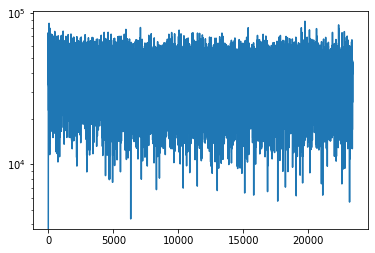

In [8]:
# Inference
# =======================================================================================================================
total_obs = 50000
total_events = 4163
batchsize = 128
sampling_proportion = [total_obs, batchsize, total_events, None]

def predictor(data):
    theta =  pyro.sample("theta", dist.StudentT(1, loc=0, scale=0.001).expand([data[1].shape[1], 1])).type(dtype)
    pred = torch.mm(data[1], theta)
    return(pred)

run = True
eta=0.1
while run:
    run = False
    pyro.clear_param_store()
    m = pcox.PCox(predictor=predictor, sampling_proportion=sampling_proportion)
    m.initialize(eta=eta, rank=50, num_particles=5)
    loss=[0]
    for __ in range(60):
        print(str(__))
        for _, __input__ in (enumerate(dataloader)):
            if torch.sum(__input__[0][:, -1]) >= 1:
              loss.append(m.infer(data=(torch.squeeze(__input__[0]), torch.squeeze(__input__[1]))))
            if loss[-1] != loss[-1]:
                break
        if loss[-1] != loss[-1]:
            eta = eta*0.1
            run = True
            break
plt.semilogy(loss)
plt.show()
plt.close()
g = m.return_guide()
out = g.quantiles([0.025, 0.5, 0.975])
UKB_loader.__disconnect__()

## Evaluation

As we know the actual true paramters - we quickly evaluate the performance of the model.


 Censorship:  0.92


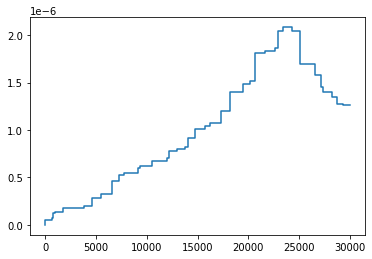

In [9]:
# Replicate main paramters from 00_fakedata
# =======================================================================================================================
np.random.seed(4523)
torch.manual_seed(9845)
I = 50000 
P_binary = 1118
P_continuous = 3
P = P_binary + P_continuous
theta = np.random.normal(0, 1, (20, 1))
theta = np.concatenate((theta[:17], np.zeros((1101, 1)), theta[-3:]))
scale = 35 

# Class for simulation
TVC = pcox.TVC(theta=theta, P_binary=P_binary, P_continuous=P_continuous, dtype=dtype)

# Sample baseline hazard - scale is set to define censorship/events
TVC.make_lambda0(scale=scale)

# gauge the number to desired level of censorship
print('\n Censorship: ', str(1 - (np.sum([torch.sum(TVC.sample()[0][:, -1]).numpy() for ii in (range(1000))])/1000)))

# Return the underlying shape of the baseline hazard and plot
t_l, ll = TVC.return_lambda0()
dt = t_l[1: ] - t_l[:-1 ]
plt.step(t_l, ll)

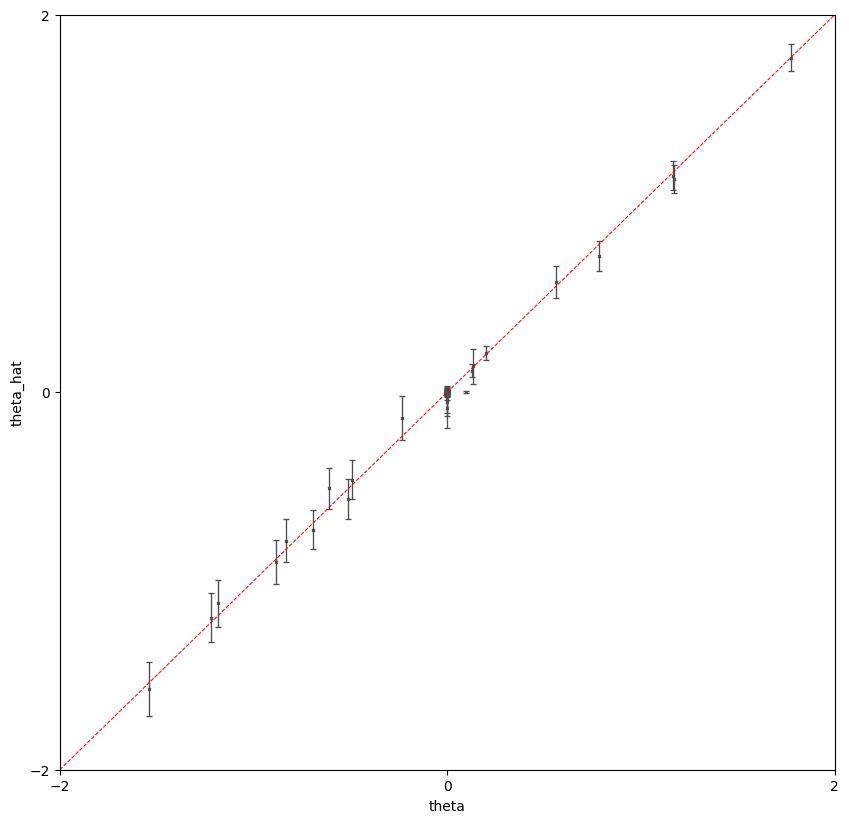

In [10]:
# Plot paramters vs estimates
# =======================================================================================================================
theta_est = out['theta'][1].detach().numpy()
theta_est_lower = out['theta'][0].detach().numpy()
theta_est_upper = out['theta'][2].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)  
ax.errorbar(theta[:, 0], theta_est[:, 0], yerr=(theta_est[:, 0] - theta_est_lower[:, 0], theta_est_upper[:, 0]- theta_est[:, 0]),  ls='', c=".3", capsize=2, capthick=0.95, elinewidth=0.95)
ax.plot(theta[:, 0], theta_est[:, 0], ls='', c=".3", marker='x', ms=2)
ax.set(xlim=(-2, 2), ylim=(-2, 2))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="red", linewidth=0.75)
ax.set_yticks([-2, 0, 2])
ax.set_ylim([-2, 2])
ax.set_xticks([-2, 0, 2])
ax.set_xlim([-2, 2])
ax.set_xlabel('theta')
ax.set_ylabel('theta_hat')
plt.show()
plt.close()

In [11]:
print('# identified non-zero effect: ', np.sum(np.sign(theta_est_lower[:, :]) == np.sign(theta_est_upper[:, :])))
print('# identified (true) non-zero effect: ', np.sum(np.sign(theta_est_lower[:20, :]) == np.sign(theta_est_upper[:20, :])))
print('# theta in HPD95%: ', np.sum(np.logical_and(theta_est_lower <= theta, theta_est_upper >= theta)))
print('# theta (non-zero) in HPD95% ', np.sum(np.logical_and(theta_est_lower <= theta, theta_est_upper >= theta)[:20]))


# identified non-zero effect:  19
# identified (true) non-zero effect:  16
# theta in HPD95%:  1120
# theta (non-zero) in HPD95%  19


## Prediction

Here we run a quick prediction accross the whole dataset and keep the survival time + the predicted value - needed for Breslow estimator (baseline hazard) + concordance for full data

In [12]:
# Linear Predictor
# =======================================================================================================================
UKB_loader = FAKE_UKB(dir=dir_fakedata + 'fake_ukb.h5')
dataloader = DataLoader(UKB_loader, batch_size=20, num_workers=1, prefetch_factor=1, persistent_workers=True, collate_fn=custom_collate, sampler=RandomSampler(np.arange(50000)), drop_last=False)
Surv = np.zeros((0, 3))
Pred = np.zeros((0, 1))
for _, __input__ in tqdm.tqdm(enumerate(dataloader)):
    Surv = np.concatenate((Surv, __input__[0].detach().numpy()))
    Pred = np.concatenate((Pred, torch.mm(__input__[1], out['theta'][1]).detach().numpy()))

2500it [01:17, 32.29it/s]


In [13]:
# Breslow estimator for baseline hazar
# =======================================================================================================================
def Breslow(surv, linpred):
    surv[surv[:, -1]==1, 1] = surv[surv[:, -1]==1, 1] - 0.0000001 # evnentsbefor censorship
    event_times = surv[surv[:, -1] ==1, 1]
    event_times = event_times[np.argsort(event_times)]
    a0 = [0]
    for ii in tqdm.tqdm(range(event_times.shape[0])):
        risk_set = (surv[:, 0] < event_times[ii]) * (event_times[ii] <= surv[:, 1])
        a0.append(1/np.sum(np.exp(linpred[risk_set])))
    return(event_times, np.asarray(a0[1:]))

tt, basehaz = Breslow(surv=Surv, linpred=Pred)
delta_time =[]
for jj in np.arange(0, tt.shape[0]-1):
    delta_time.append(tt[jj+1] - tt[jj])
delta_time.append(0.1)
delta_time = np.asarray(delta_time)[:, None]

delta_time = np.asarray([np.sum(delta_time[jj==tt], axis=0) for jj in np.unique(tt)])
basehaz = np.asarray([np.sum(basehaz[jj==tt], axis=0) for jj in np.unique(tt)])[:, None]
tt = np.unique(tt)
basehaz = basehaz/delta_time
A0 = np.copy(basehaz)

100%|██████████| 4163/4163 [00:22<00:00, 187.23it/s]


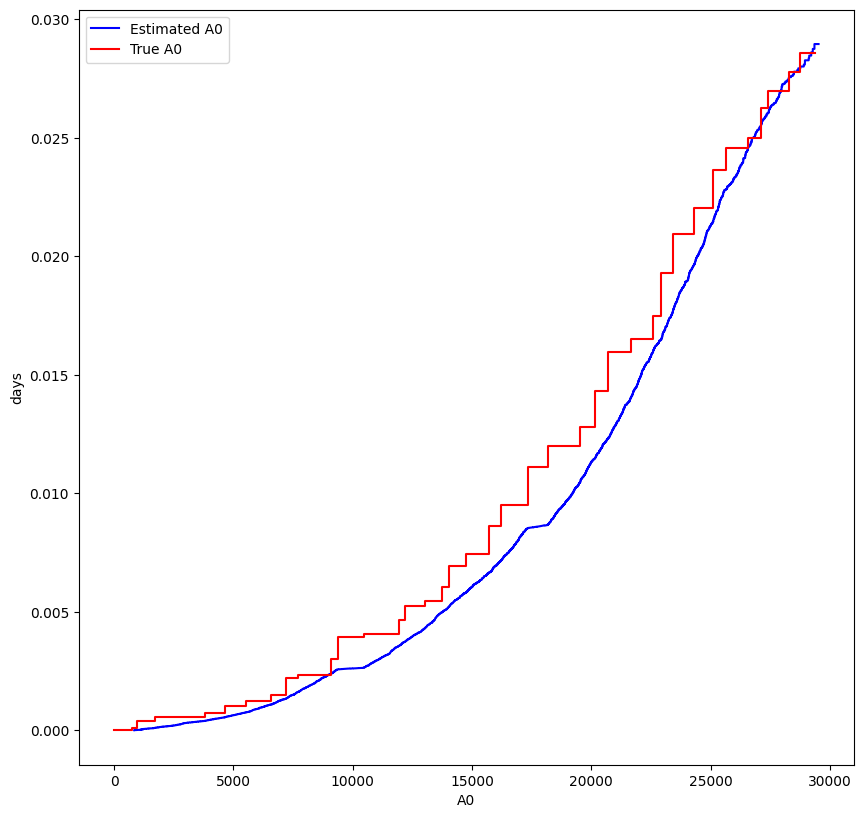

In [14]:
# Breslow estimator comparision with true A0  (median estimate)
# =======================================================================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)  
ax.step(tt[:-1], np.cumsum(basehaz[:-1] * delta_time[:-1]), color='blue', label='Estimated A0')
ax.step(t_l[:-1], np.cumsum(ll[:-1, 0] * dt), color='red',  label='True A0')
ax.set_xlabel('A0')
ax.set_ylabel('days')
ax.legend()
plt.show()
plt.close()

In [15]:
# Concordance index
# =======================================================================================================================
pcox.metrics(surv=Surv, linpred=Pred, processes=4).concordance()

0.948049257674758

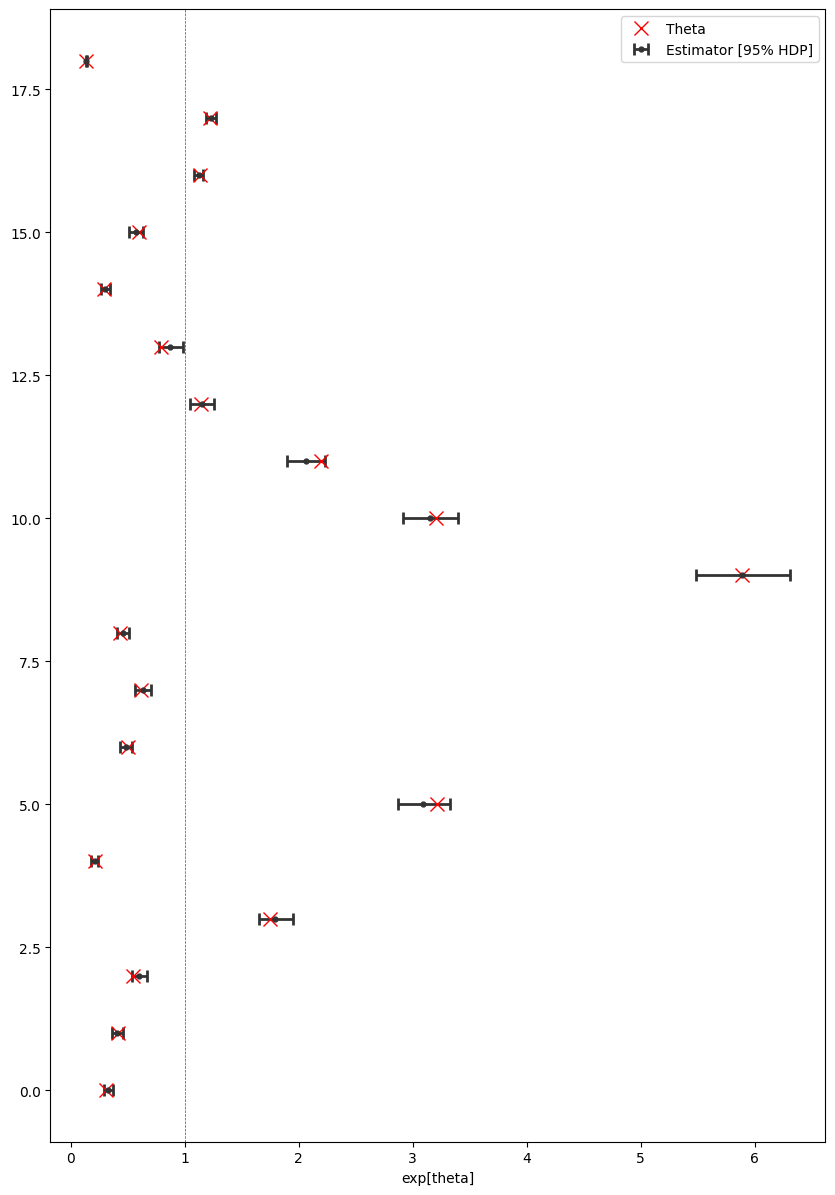

In [17]:
# Forest Plot
# =======================================================================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 15), dpi=100)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.0)

theta_lower = np.exp(out['theta'][0].detach().numpy())
theta_est = np.exp(out['theta'][1].detach().numpy())
theta_upper = np.exp(out['theta'][2].detach().numpy())

sign = np.sign(out['theta'][0].detach().numpy()[:]) == np.sign(out['theta'][2].detach().numpy()[:])
sign = sign[:, 0]

theta_lower = theta_lower[:][sign]
theta_est = theta_est[:][sign]
theta_upper = theta_upper[:][sign]
theta_add = theta[:][sign]

ax.errorbar(y=range(np.sum(sign)), x=theta_est, xerr=(theta_est - theta_lower, theta_upper - theta_est),  c='.2', ls='', marker='.', markersize='7', linewidth=2, capthick=2, capsize=4, label='Estimator [95% HDP]')
ax.axvline(1, linewidth=0.5, c='r', ls='--')
ax.plot(np.exp(theta_add), range(np.sum(sign)), ls='', marker='x', color='red', ms=10, label='Theta')
ax.set_xlabel('exp[theta]')
plt.legend()

plt.show()
plt.close()